In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from PIL import Image

import sys
sys.path.append("../")

from utils.prep_utils import (
    COLORMAP,
    heatmaps_to_coordinates,
    N_KEYPOINTS,
    RAW_IMG_SIZE,
    MODEL_IMG_SIZE,
    show_batch_predictions,
    show_own_predictions,
    DATASET_MEANS,
    DATASET_STDS,
)
from utils.model import ShallowUNet
from utils.dataset import FreiHAND

from torchvision import transforms
import io
import os

#os.environ['CUDA_VISIBLE_DEVICES'] ='0'

C:\Users\user2\.conda\envs\torch1101py37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    "data_dir": "D:/Users/user2/Desktop/hand_landmark/Dataset/FreiHAND_pub_v2",
    "model_path": "D:/Users/user2/Desktop/2D-Hand-Pose-Estimation-RGB/weights/hand_keypoint.pt",
    "test_batch_size": 4,
    "device": "cpu",
}

test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

image_names: 130240
K_matrix: 130240
anno: 130240


In [3]:
'''
#load 不含架構的權重
model = ShallowUNet(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
'''


#load 含架構的權重
model = torch.load(config["model_path"])
model = model.to(config["device"])

model.eval()
print("Model loaded")

Model loaded


In [5]:
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:56<00:00,  6.86it/s]


In [6]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 4.2% from image size
Average error per keypoint: 5 pixels for image 128x128
Average error per keypoint: 9 pixels for image 224x224


torch.Size([4, 3, 128, 128])


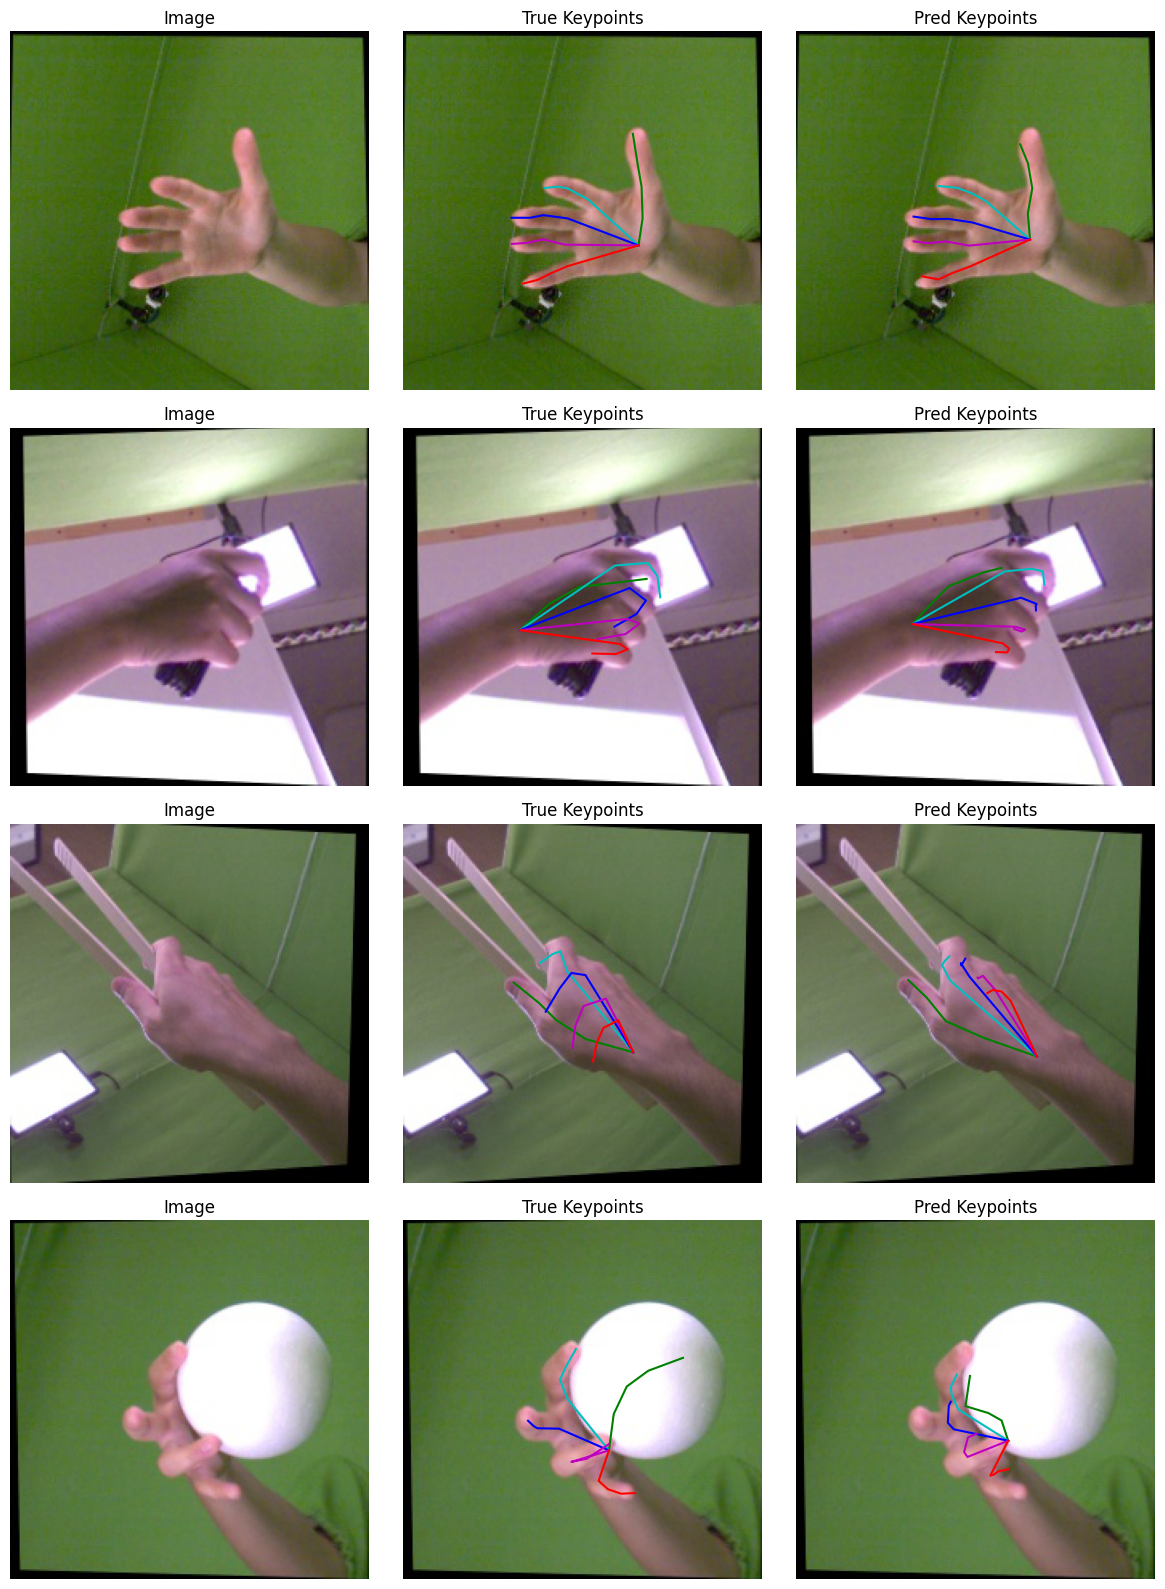

In [7]:
for data in test_dataloader:
    print(data["image"].size())
    show_batch_predictions(data, model)
    break

## Test on Own Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])


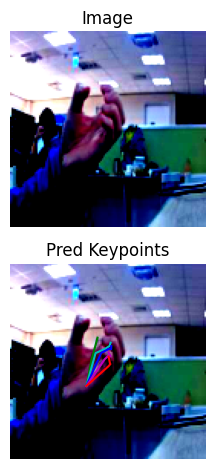

In [16]:
#data = Image.open('D:/Users/user2/Desktop/2D-Hand-Pose-Estimation-RGB/data/own_test/00000252.jpg')
data = Image.open('D:/Users/user2/Desktop/2D-Hand-Pose-Estimation-RGB/data/own_test/0112 (20).jpg')

image_transform = transforms.Compose(
    [
        transforms.Resize(MODEL_IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
    ]
)

data = image_transform(data)
print(data.size())
data = np.expand_dims(data,axis=0)
data = torch.from_numpy(data)

show_own_predictions(data, model)